这是一个用于将图像和星表文件处理成训练集的代码
- created by hyz
- begin in 2023.02.15

In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
import torch
import pandas as pd
import os

fits文件和cat文件的路径

cf_s v0.0

In [2]:
fits_path = '/home/haoyanzhen_shao/project/simulation_work/_backup/CrowdedField20230219p/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_07_L0_1.fits'
cat_path = '/home/haoyanzhen_shao/project/simulation_work/_backup/CrowdedField20230219p/MSC_0000000/MSC_100000000_chip_07_filt_i.cat'


cf_l v1.0

In [2]:
fits_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230222/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_08_L0_1.fits'
cat_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230222/MSC_0000000/MSC_100000000_chip_08_filt_g.cat'

cf_l v2.0

In [9]:
fits_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230320/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_08_L0_1.fits'
cat_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230320/MSC_0000000/MSC_100000000_chip_08_filt_g.cat'

Ant v1.0 00-08

In [12]:
fits_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/Ant_simulation20230310/MSC_0000000/CSST_MSC_MS_SCI_20260310003533_20260310003803_100000000_08_L0_1.fits'
cat_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/Ant_simulation20230310/MSC_0000000/MSC_100000000_chip_08_filt_g.cat'

### 读取fits和cat文件

In [10]:
# read cat to pandas.DataFrame
with open(cat_path,'r') as f:
    names = f.readlines()[0].strip()[1:].split(' ')[1:]
cat = pd.read_csv(cat_path,delim_whitespace=True,names=names,comment='#')

# read fits to np.array
img_hdu = fits.open(fits_path)
img_meta = img_hdu[1].data

# 分割图像

#### cnn

In [4]:
side_pixels = 100
side_overlap = 0
nx_split = (img_meta.shape[0]-side_pixels)//(side_pixels-side_overlap) +1   # 去边角料后的x轴图像数
ny_split = (img_meta.shape[1]-side_pixels)//(side_pixels-side_overlap) +1   # 去边角料后的y轴图像数
nxp_split = nx_split*side_pixels - (nx_split-1)*side_overlap                # 去边后x像素数
nyp_split = ny_split*side_pixels - (ny_split-1)*side_overlap                # 去边后y像素数

# 清除上期数据
if os.path.exists('dataset/image/0_0.fits'):
    os.system('rm ./dataset/image/*')
if os.path.exists('dataset/catalog/0_0.csv'):
    os.system('rm ./dataset/catalog/*')

# fits
head0 = img_hdu[0].header
head1 = img_hdu[1].header
head0['PIXSIZE1'] = head0['PIXSIZE2'] = head1['NAXIS1'] = head1['NAXIS2'] = side_pixels
for i in np.arange(0, nxp_split-side_overlap, side_pixels-side_overlap):
    for j in np.arange(0, nyp_split-side_overlap, side_pixels-side_overlap):
        hdu0 = fits.PrimaryHDU()
        hdu0.header = head0
        hdu1 = fits.ImageHDU()
        hdu1.header = head1
        hdu1.data = img_meta[i:i+side_pixels,j:j+side_pixels]
        hdul = fits.HDUList([hdu0,hdu1])
        hdul.writeto('./dataset/image/%s_%s.fits'%(i,j),overwrite=True)
        cat.query('xImage > %f and xImage < %f and yImage > %f and yImage < %f' % (i,i+side_pixels,j,j+side_pixels)).to_csv('dataset/catalog/%d_%d.csv'%(i,j))

# png
# for i in np.arange(0, img_meta.shape[0], side_pixels-side_overlap):
#     for j in np.arange(0, img_meta.shape[1], side_pixels-side_overlap):
#         plt.imsave('dataset/image/%d_%d.png'%(i,j),img_meta[i:i+side_pixels,j:j+side_pixels])
#         cat.query('xImage > %f and xImage < %f and yImage > %f and yImage < %f' % (i,i+side_pixels,j,j+side_pixels)).to_csv('dataset/catalog/%d_%d.csv'%(i,j))

# del img_meta
# del cat

## refinedet

### sex-->reg

In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd


_acat = './__data__/cf3e8.cat'
sex_cat = fits.open(_acat)[2].data
sex_cat = Table(sex_cat)

_catr = '/media/hyz/dwarfcave/data/csst_simulation/nn_cf/dataset/CrowdedField20230222/MSC_0000000/MSC_100000000_chip_08_filt_g.cat'
with open(_catr,'r') as f:
    names = f.readlines()[0].strip()[1:].split(' ')[1:]
cat_raw = pd.read_csv(_catr,delim_whitespace=True,names=names,comment='#')


In [2]:
lenc = len(sex_cat)
_reg = _acat[0:-4] + '_sex.reg'
with open(_reg, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(lenc):
        f.writelines("ellipse("+str(sex_cat['XWIN_IMAGE'][i])+","+str(sex_cat['YWIN_IMAGE'][i])+
                    ","+str(4*sex_cat['AWIN_IMAGE'][i])+","+str(4*sex_cat['BWIN_IMAGE'][i])+","
                    +str(sex_cat['THETAWIN_IMAGE'][i])+")\n")
sex_cat[:2]


X_IMAGE,Y_IMAGE,ERRA_IMAGE,ERRB_IMAGE,XWIN_IMAGE,YWIN_IMAGE,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,ISOAREAF_IMAGE,ISOAREAF_WORLD,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,MAGERR_AUTO,ALPHA_J2000,DELTA_J2000,ELLIPTICITY,ALPHAWIN_J2000,DELTAWIN_J2000,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_J2000,X_WORLD,Y_WORLD,FWHM_IMAGE,FLAGS
float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int32,int32,int32,int32,float32,float64,float64,float32,float64,float64,float32,float32,float32,float64,float64,float32,int16
3512.9912,1.0,0.08839413,0.029479416,3512.7901206902857,1.3198228628122775,1.2433749912405712,0.3571128799491423,0.007813521891600471,0.0008690360002174341,0.088966124,0.07395195,-0.061930936,0.80576473,2.805465,1.1154855,0.5968081,-1.8574021,11997.8125,616.5296,642.4304,3,2.3148148e-07,3512,3514,1,1,0.0558061,270.9689183811676,-40.707094342663915,0.6614666,270.96891258989103,-40.70710074847979,1.8286261e-06,1.5201933e-06,-23.368736,270.9689183811676,-40.707094342663915,2.8947265,24
8833.017,1.0,0.07673778,0.025597313,8833.105023024053,1.0855002615102436,0.7336232934141007,0.08864083756646644,0.00588868629140162,0.0006552224300844131,0.062190615,0.050689325,0.15906323,1.37969,11.418809,0.85722435,0.2956866,2.4780521,10227.974,551.9597,619.0438,3,2.3148148e-07,8832,8834,1,1,0.058606748,270.91168393893776,-40.60673171940381,0.6594646,270.91168086075766,-40.60673074232977,1.2784502e-06,1.0417392e-06,-23.493896,270.91168393893776,-40.60673171940381,2.8857102,24


In [3]:
lencr = len(cat_raw)
_regr = _acat[0:-4] + '_raw.reg'
with open(_regr, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=red dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(lencr):
        f.writelines("circle("+str(cat_raw['xImage'][i])+","+str(cat_raw['yImage'][i])+","+str((28-cat_raw['mag'][i])**0.5)+")\n")


### kdtree

In [12]:
from _utils import kdmatching
import os

_acat = './__data__/20230219p.cat'
_catr = '/media/hyz/dwarfcave/data/csst_simulation/simulation_work/_backup/CrowdedField20230219p/MSC_0000000/MSC_100000000_chip_07_filt_i.cat'
if not os.path.exists(_catr):
    _catr = '/home/haoyanzhen_shao/project/simulation_work/_backup/CrowdedField20230219p/MSC_0000000/MSC_100000000_chip_07_filt_i.cat'
cat0ss,cat1ss = kdmatching(_acat,_catr)
cat0ss.shape, cat1ss.shape

((99093, 6), (99093, 6))

##### kdtree分节代码

In [32]:
# a spatial matching with kdtree.
# extremely matching stars with two cat, each experiencing a sole match.
# created by hyz in 2023.03.21

from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np


sex_cat = fits.open(_acat)[2].data
sex_cat = Table(sex_cat)

with open(_catr,'r') as f:
    names = f.readlines()[0].strip()[1:].split(' ')[1:]
cat_raw = pd.read_csv(_catr,delim_whitespace=True,names=names,comment='#')
lenc = len(sex_cat)
_reg = _acat[0:-4] + '_sex.reg'
with open(_reg, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=green dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(lenc):
        f.writelines("ellipse("+str(sex_cat['XWIN_IMAGE'][i])+","+str(sex_cat['YWIN_IMAGE'][i])+
                    ","+str(4*sex_cat['AWIN_IMAGE'][i])+","+str(4*sex_cat['BWIN_IMAGE'][i])+","
                    +str(sex_cat['THETAWIN_IMAGE'][i])+")\n")
sex_cat

X_IMAGE,Y_IMAGE,ERRA_IMAGE,ERRB_IMAGE,XWIN_IMAGE,YWIN_IMAGE,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,THETAWIN_IMAGE,FLUX_AUTO,FLUXERR_AUTO,BACKGROUND,ISOAREAF_IMAGE,ISOAREAF_WORLD,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,MAGERR_AUTO,ALPHA_J2000,DELTA_J2000,ELLIPTICITY,ALPHAWIN_J2000,DELTAWIN_J2000,ERRAWIN_WORLD,ERRBWIN_WORLD,ERRTHETAWIN_J2000,X_WORLD,Y_WORLD,FWHM_IMAGE,FLAGS
float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int32,int32,int32,int32,float32,float64,float64,float32,float64,float64,float32,float32,float32,float64,float64,float32,int16
3512.9912,1.0,0.08839413,0.029479416,3512.7901206902857,1.3198228628122775,1.2433749912405712,0.3571128799491423,0.007813521891600471,0.0008690360002174341,0.088966124,0.07395195,-0.061930936,0.80576473,2.805465,1.1154855,0.5968081,-1.8574021,11997.8125,616.5296,642.4304,3,2.3148148e-07,3512,3514,1,1,0.0558061,270.9689183811676,-40.707094342663915,0.6614666,270.96891258989103,-40.70710074847979,1.8286261e-06,1.5201933e-06,-23.368736,270.9689183811676,-40.707094342663915,2.8947265,24
8833.017,1.0,0.07673778,0.025597313,8833.105023024053,1.0855002615102436,0.7336232934141007,0.08864083756646644,0.00588868629140162,0.0006552224300844131,0.062190615,0.050689325,0.15906323,1.37969,11.418809,0.85722435,0.2956866,2.4780521,10227.974,551.9597,619.0438,3,2.3148148e-07,8832,8834,1,1,0.058606748,270.91168393893776,-40.60673171940381,0.6594646,270.91168086075766,-40.60673074232977,1.2784502e-06,1.0417392e-06,-23.493896,270.91168393893776,-40.60673171940381,2.8857102,24
1053.3024,1.2958347,0.05841112,0.034179304,1053.0789213484143,1.1078090842617143,0.28208307286952455,0.10283884912221593,0.0022883232987631853,0.0022917608780207844,0.048649665,0.041745946,-0.3709529,3.549368,9.735782,0.5312998,0.32037854,-1.895062,8090.648,533.157,597.531,3,2.3148148e-07,1053,1054,2,1,0.07156516,270.9954318101553,-40.753490052160736,0.3661763,270.9954389029658,-40.75349273052422,9.997882e-07,8.5835313e-07,-23.158463,270.9954318101553,-40.753490052160736,1.0982147,24
1146.9688,1.2084115,0.04651806,0.02855174,1146.9328653982993,1.0414845129422108,0.27843626084098455,0.11415630565749643,0.0021638959883084085,0.0008152358580884447,0.026191697,0.022075314,0.85989213,3.5915859,8.760162,0.5276757,0.3378623,-0.3274772,9976.758,440.08023,590.33203,4,3.0864197e-07,1146,1148,2,1,0.04790405,270.9944233793127,-40.751722760602334,0.40327895,270.9944279219551,-40.751722072211564,5.3865915e-07,4.5342875e-07,-24.057169,270.9944233793127,-40.751722760602334,1.6999985,24
1648.7738,1.343692,0.041926846,0.024532152,1648.8030483486532,1.0743266933240105,0.24567745835178237,0.06907544158052197,0.0016444874984886029,0.0007151992986915917,0.02743625,0.022351071,0.5575462,4.072509,14.484506,0.49570933,0.2627264,-0.9665322,11697.8545,462.27194,622.45624,5,3.8580248e-07,1648,1650,2,1,0.04291619,270.98900673065305,-40.74225951418611,0.37034023,270.98901312125764,-40.74225676213375,5.6418276e-07,4.5915584e-07,-23.834297,270.98900673065305,-40.74225951418611,1.6073581,24
2317.715,1.4329383,0.083576694,0.025673188,2317.5118438506115,2.020405988463492,5.475450159774239,1.8551683357134763,0.0069669434352642055,0.000677232718315796,0.13266395,0.11085543,0.04682252,0.18263838,0.5390494,2.3399844,1.3620175,-0.2636927,32500.334,1149.6746,572.625,11,8.487654e-07,2315,2320,2,1,0.038416423,270.9817906362384,-40.729643230374535,0.6817945,270.9817782059324,-40.729651864619406,2.7270078e-06,2.2785664e-06,-23.456917,270.9817906362384,-40.729643230374535,5.1555357,25
2358.6611,1.3611714,0.045876656,0.021281267,2358.6297143707916,1.0656073548363083,0.30024027300771566,0.058039889338440225,0.0020684532260492852,0.0004891065341882935,0.025736466,0.01954609,0.23590304,3.3334541,17.243954,0.54799676,0.24078979,-0.90288246,15203.529

In [36]:
lencr = len(cat_raw)
_regr = _acat[0:-4] + '_raw.reg'
with open(_regr, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=red dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(lencr):
        f.writelines("circle("+str(cat_raw['xImage'][i])+","+str(cat_raw['yImage'][i])+","+str((28-cat_raw['mag'][i])**0.5)+")\n")
cat_raw

,obj_ID,ID_chip,filter,xImage,yImage,ra,dec,ra_orig,dec_orig,z,...,av,redden,pm_ra,pm_dec,RV,parallax,model_tag,teff,logg,feh
0,92,7,i,7789.550,3916.498,271.083150,-40.577089,271.076587,-40.577887,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',3727.2528,4.0620,-0.5213
1,1207,7,i,7118.865,5222.564,271.058158,-40.600333,271.051590,-40.601131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',3452.6644,3.9531,-0.4171
2,2002,7,i,7853.175,5421.682,271.045370,-40.588172,271.038803,-40.588969,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',3727.5333,3.7126,-0.4766
3,3146,7,i,8681.043,5501.489,271.034530,-40.573289,271.027964,-40.574084,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',8778.0106,3.6331,0.2524
4,3214,7,i,8789.261,2733.291,271.101574,-40.548662,271.095015,-40.549461,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',4101.1907,4.4106,-0.5009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156422,7998806,7,i,822.610,4834.530,271.135431,-40.715355,271.128857,-40.716162,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',2976.4954,4.4458,-0.8956
156423,7998972,7,i,687.237,8996.225,271.034038,-40.751870,271.027455,-40.752673,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',3574.7878,4.3997,-0.9619
156424,7999288,7,i,4722.302,6864.339,271.043381,-40.658727,271.036808,-40.659527,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',4868.4842,4.4398,-0.7812
156425,7999467,7,i,775.333,8278.221,271.050845,-40.744367,271.044263,-40.745171,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,b'phoe',2707.7951,3.6204,-0.9715


In [37]:
from scipy import spatial

cat0 = sex_cat.to_pandas()[['XWIN_IMAGE','YWIN_IMAGE','AWIN_IMAGE','BWIN_IMAGE','THETAWIN_IMAGE',
                            'ISOAREAF_IMAGE' ]]
cat0 = cat0.to_numpy()
tree0 = spatial.KDTree(cat0[:,:2])
cat0nb = tree0.query(cat0[:,:2],k=[2])
cat0nb = np.array(cat0nb)
cat0nb = cat0nb.squeeze()
index0 = np.where(cat0nb[0,:]>cat0[:,2])[0]
cat0s = cat0[index0]
cat0s.shape


(558559, 6)

In [38]:
tree0s = spatial.KDTree(cat0s[:,:2])

cat1 = cat_raw[['xImage','yImage','mag']].to_numpy()
tree1 = spatial.KDTree(cat1[:,:2])
cat1nb = tree1.query(cat1[:,:2],k=[2])
cat1nb = np.array(cat1nb)
cat1nb = cat1nb.squeeze()
index1 = np.where(cat1nb[0,:]>(28-cat1[:,2])**0.5)[0]
cat1s = cat1[index1]
cat1s.shape

(150989, 3)

In [259]:
tree1s = spatial.KDTree(cat1s[:,:2])
cat01nb = tree1s.query(cat0s[:,:2],k=[1])
cat01nb = np.array(cat01nb)
cat01nb = cat01nb.squeeze()
index01 = np.where(cat01nb[0,:]<cat0s[:,2])[0]

cat0ss = cat0s[index01]
cat1ss = cat1s[np.int32(cat01nb[1,index01])]
cat0ss.shape, cat1ss.shape

((99332, 6), (99332, 3))

In [260]:
len0 = len(cat0ss)
_reg0 = './__data__/nearby_0.reg'
with open(_reg0, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=blue dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(len0):
        f.writelines("ellipse("+str(cat0ss[i,0])+","+str(cat0ss[i,1])+
                    ","+str(4*cat0ss[i,2])+","+str(4*cat0ss[i,3])+","
                    +str(cat0ss[i,4])+")\n")

len1 = len(cat1ss)
_reg1 = './__data__/nearby_1.reg'
with open(_reg1, 'w') as f:
    f.write("# Region file format: DS9 version 4.1\nglobal color=cyan dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
    for i in range(len1):
        f.writelines("circle("+str(cat1ss[i,0])+","+str(cat1ss[i,1])+","+str((28-cat1ss[i,2])**0.5)+")\n")


### 星等-半径关系拟合

In [98]:
import numpy as np

mag = cat1ss[:,2]  # mag
size = cat0ss[:,5]  # ISOAREAF_IMAGE 等光圈面积
side = (size/np.pi)**0.5
mag,size,side

(array([23.2277, 23.4121, 23.0963, ..., 22.539 , 21.8034, 23.0911]),
 array([ 5.,  6.,  6., ..., 17., 24., 13.]),
 array([1.26156626, 1.3819766 , 1.3819766 , ..., 2.32621325, 2.7639532 ,
        2.03421447]))

Text(0.5, 1.0, 'mag-radius')

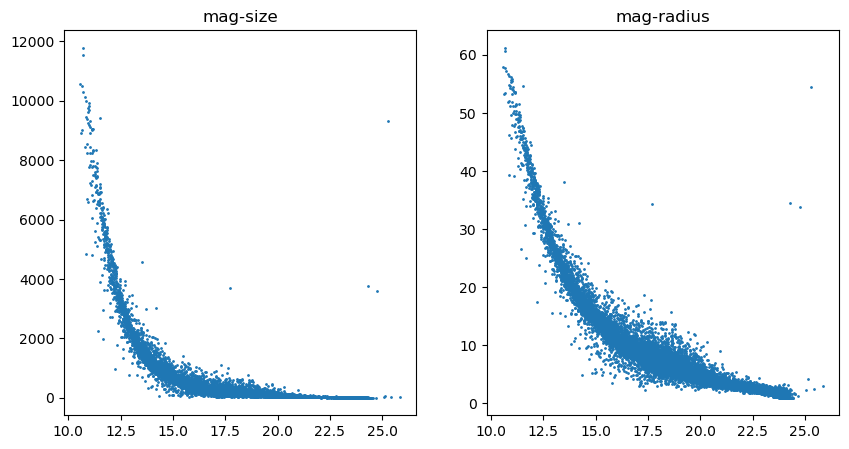

In [99]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(mag,size,s=1)
plt.title('mag-size')
plt.subplot(122)
plt.scatter(mag,side,s=1)
plt.title('mag-radius')

#### 以下为废弃拟合

三次多项式

In [7]:
from scipy.optimize import curve_fit
def side_mag(mag,a,b,c,d):
    return a*mag**3+b*mag**2+c*mag+d

popts,pcov,info,mesg,flg = curve_fit(side_mag,mag,side,full_output=True)
popts,pcov

(array([-3.51249625e-02,  2.23709381e+00, -4.80437967e+01,  3.51022769e+02]),
 array([[ 7.69256207e-09, -4.35569761e-07,  8.07359774e-06,
         -4.88558897e-05],
        [-4.35569761e-07,  2.47498122e-05, -4.60536501e-04,
          2.79874793e-03],
        [ 8.07359774e-06, -4.60536501e-04,  8.60677101e-03,
         -5.25596889e-02],
        [-4.88558897e-05,  2.79874793e-03, -5.25596889e-02,
          3.22771834e-01]]))

Text(0.5, 1.0, 'mag-radius fit')

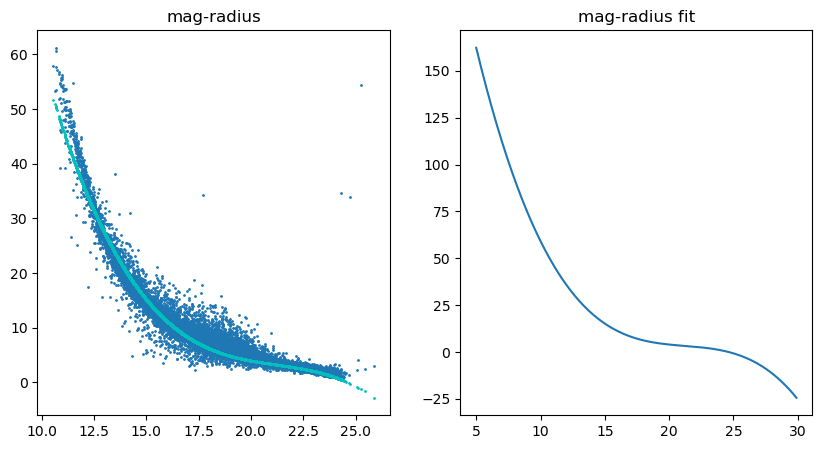

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(mag,side,s=1)
plt.scatter(mag,side_mag(mag,popts[0],popts[1],popts[2],popts[3]),c='c',s=1)
plt.title('mag-radius')
plt.subplot(122)
plt.plot(np.arange(5,30,0.1),side_mag(np.arange(5,30,0.1),popts[0],popts[1],popts[2],popts[3]))
plt.title('mag-radius fit')


由于缺乏5-10星等的点，较亮的星拟合较差。实际上星的最高展宽大概在110个像素左右

In [74]:
amag = np.hstack((mag,np.random.rand(10000)*3+5))
aside = np.hstack((side,np.random.rand(10000)*3+110))
from scipy.optimize import curve_fit
def side_mag(mag,a,b,c,d,e):
    return ((np.exp(a*c-a*mag)-e*np.exp(-a*c+a*mag))/(e*np.exp(-a*c+a*mag)+np.exp(a*c-a*mag)))*b+d

popts,pcov,info,mesg,flg = curve_fit(side_mag,amag,aside,p0=(0.2,10,55,55,0.5),full_output=True)
popts,pcov

/home/hyz/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/hyz/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


(array([  -1.07031009,  -37.2965448 , -138.7644463 ,   52.5771471 ,
          39.24650722]),
 array([[inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf]]))

Text(0.5, 1.0, 'mag-radius fit')

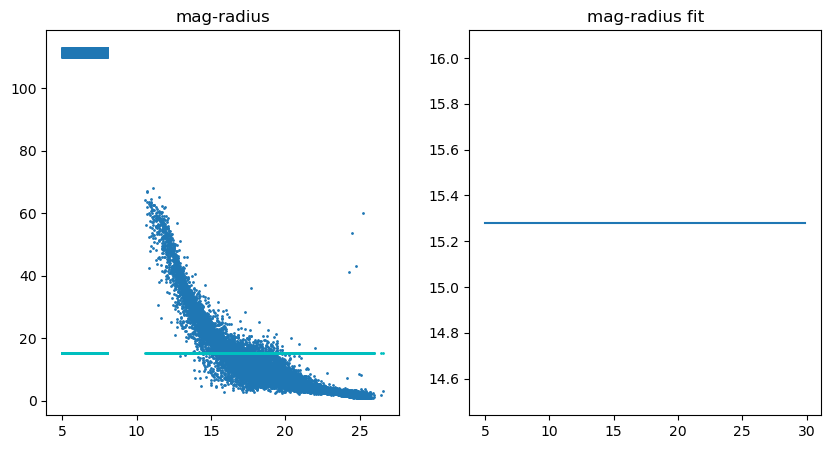

In [75]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(amag,aside,s=1)
plt.scatter(amag,side_mag(amag,popts[0],popts[1],popts[2],popts[3],popts[4]),c='c',s=1)
plt.title('mag-radius')
plt.subplot(122)
plt.plot(np.arange(5,30,0.1),side_mag(np.arange(5,30,0.1),popts[0],popts[1],popts[2],popts[3],popts[4]))
plt.title('mag-radius fit')
# popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],

Text(0.5, 1.0, 'mag-radius fit')

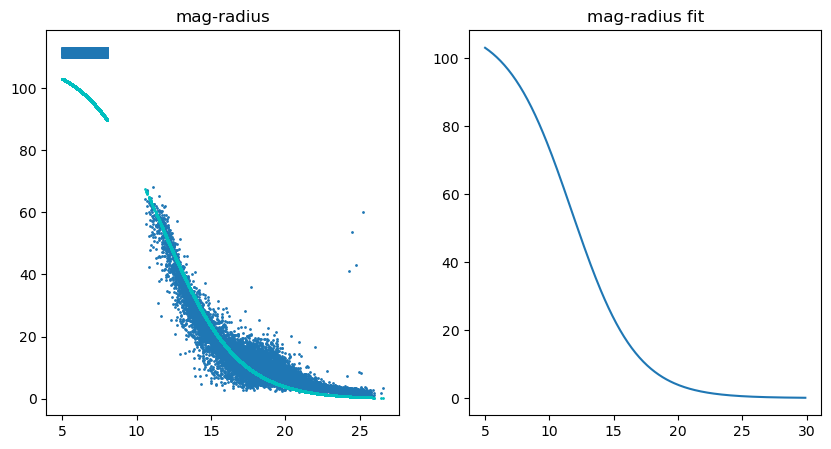

In [66]:
def tanhh(mag):
    a=0.2
    c=10
    b=55
    d=55
    e=0.5
    return ((np.exp(a*c-a*mag)-e*np.exp(-a*c+a*mag))/(e*np.exp(-a*c+a*mag)+np.exp(a*c-a*mag)))*b+d

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(amag,aside,s=1)
plt.scatter(amag,tanhh(amag),c='c',s=1)
plt.title('mag-radius')
plt.subplot(122)
plt.plot(np.arange(5,30,0.1),tanhh(np.arange(5,30,0.1)))
plt.title('mag-radius fit')
# popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],

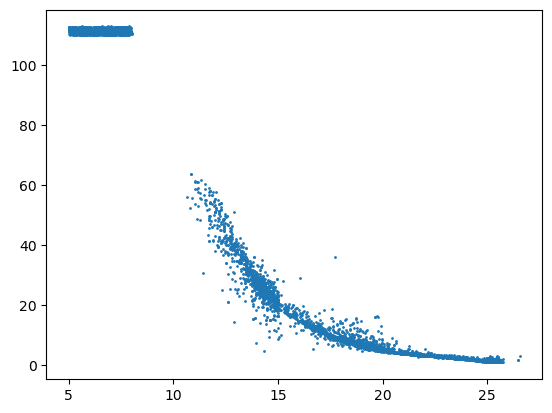

In [62]:
rstate = np.random.get_state()
rmag = np.hstack((np.random.choice(amag[(amag>5)&(amag<10)],1000),
                  np.random.choice(amag[(amag>10)&(amag<15)],1000),
                  np.random.choice(amag[(amag>15)&(amag<20)],1000),
                  np.random.choice(amag[(amag>20)&(amag<25)],1000),
                  np.random.choice(amag[(amag>25)&(amag<30)],1000),
                  ))
np.random.set_state(rstate)
rside = np.hstack((np.random.choice(aside[(amag>5)&(amag<10)],1000),
                  np.random.choice(aside[(amag>10)&(amag<15)],1000),
                  np.random.choice(aside[(amag>15)&(amag<20)],1000),
                  np.random.choice(aside[(amag>20)&(amag<25)],1000),
                  np.random.choice(aside[(amag>25)&(amag<30)],1000),
                  ))
plt.scatter(rmag,rside,s=1)

#### 四参数sinh函数拟合

In [9]:
# 添加部分亮星数据
amag = np.hstack((mag,np.random.rand(100)*5+5))
aside = np.hstack((side,np.random.rand(100)*2+50))
rmag = amag
rside = aside
# rmag, rside = mag, side

Text(0.5, 1.0, 'mag-radius fit')

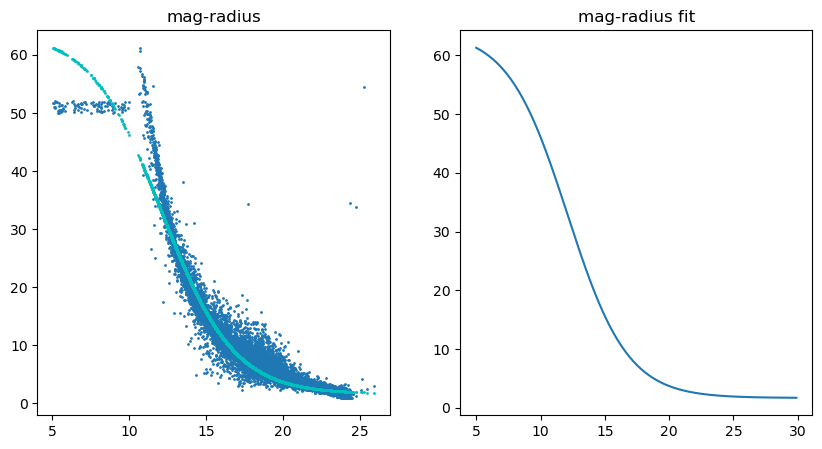

In [10]:
from scipy.optimize import curve_fit
def side_mag(mag,a,b,c,d,e):
    return ((np.exp(a*c-a*mag)-e*np.exp(-a*c+a*mag))/(e*np.exp(-a*c+a*mag)+np.exp(a*c-a*mag)))*b+d

popts,pcov= curve_fit(side_mag,rmag,rside,p0=(0.2,55,10,55,0.5),method='lm')
popts,pcov
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(rmag,rside,s=1)
plt.scatter(rmag,side_mag(rmag,popts[0],popts[1],popts[2],popts[3],popts[4]),c='c',s=1)
plt.title('mag-radius')
plt.subplot(122)
plt.plot(np.arange(5,30,0.1),side_mag(np.arange(5,30,0.1),popts[0],popts[1],popts[2],popts[3],popts[4]))
plt.title('mag-radius fit')
# popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],

In [53]:
np.save('./__data__/mag_radius_popt.npy',popts)
popts,popts[0]*popts[2],side_mag(26,*popts)

(array([ 0.21604804, 30.78140974, 10.27157584, 32.47358702,  0.44252968]),
 2.2191538577869547,
 1.8473202883407502)

双正切曲线拟合公式：**$$side=\frac{e^{2.52-0.25*mag}-0.47*e^{0.25*mag-2.52}}{e^{2.52-0.25*mag}+0.47*e^{0.25*mag-2.52}}*58.98+61.87$$**

拟合测试

In [1]:
import numpy as np
import _utils


mag_radius = np.load('./__data__/mag_radius_popt.npy')

In [12]:
mag = 14
_utils.mag_side(mag,*mag_radius)

27.47951924456494

succ

注：不太对，这里sex测的还是很准的，问题在于我的估计。虽然半高全宽随星等的减小而保持不变，但是星像半径却并非如此，会随着星等的变小而不断增加。

我不认为我们的望远镜有光子抑制局限，最大限制很可能是代码当中设置的上限。然而实际上在其他图像里很少看到这样的图像。先尝试一个分段多次拟合(失败)

#### 神经网络拟合

##### mag-size

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


class Mag2Side(nn.Module):
    def __init__(self):
        super(Mag2Side,self).__init__()
        self.fc1 = nn.Linear(1,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,10)
        self.fc4 = nn.Linear(10,1)
        self.a1 = nn.Sigmoid()
        self.a2 = nn.Sigmoid()
        self.a3 = nn.Sigmoid()
        # self.a4 = nn.ReLU()
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.fc1(x)
        x = self.a1(x)
        x = self.fc2(x)
        # x = self.relu(x)
        # x = self.a2(x)
        x = self.fc3(x)
        # x = self.relu(x)
        # x = self.a3(x)
        x = self.fc4(x)
        # x = self.relu(x)
        # x = self.a4(x)
        return x


class CSSTSimDataset(Dataset):
    def __init__(self,datas,labels,transfrom=None):
        self.datas = datas
        self.labels = labels
    
    def __getitem__(self, index):
        data = torch.tensor(self.datas[index])
        label = torch.tensor(self.labels[index])
        return data, label
    
    def __len__(self):
        return len(self.labels)
    
dataset = CSSTSimDataset(mag,side)
batch = 1000

trainloader = DataLoader(dataset,shuffle=True,batch_size=batch,num_workers=0)

net = Mag2Side()
net.train()
optimizer = optim.Adam(net.parameters(),lr=0.02)

for epoch in range(10):
    optimizer = optim.Adam(net.parameters(),lr=0.02*np.exp(-epoch/20))
    for idx,(data,label) in enumerate(trainloader):
        optimizer.zero_grad()
        out = net(data.float().unsqueeze(1))
        # print(out.squeeze(),'\n',label,'\n',out.squeeze()-label)
        loss = torch.mean((out.squeeze()-label)**2)
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            print(loss)

In [192]:
np.exp(-100/20)

0.006737946999085467

In [186]:
net(torch.tensor(30).unsqueeze(0).float()).data

tensor([1.9099])

Text(0.5, 1.0, 'mag-radius fit')

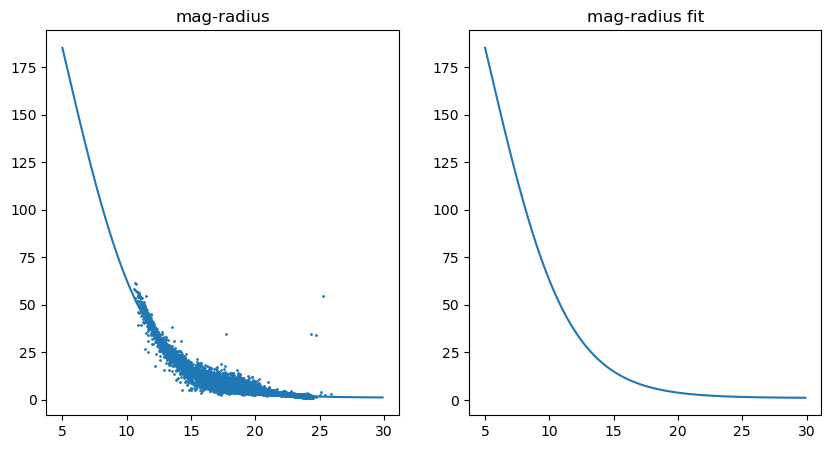

In [202]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(mag,side,s=1)
plt.plot(torch.arange(5,30,0.1),net(torch.tensor(np.arange(5,30,0.1)).unsqueeze(1).float()).squeeze().data)
plt.title('mag-radius')
plt.subplot(122)
plt.plot(torch.arange(5,30,0.1),net(torch.tensor(np.arange(5,30,0.1)).unsqueeze(1).float()).squeeze().data)
plt.title('mag-radius fit')

In [ ]:
torch.save(net.state_dict(),'__data__/mag2side_net.pth')

In [30]:
from _utils import Mag2Side

net = Mag2Side()
net.load_state_dict(torch.load('__data__/mag2side_net.pth'))
net(torch.tensor(22).unsqueeze(0).float())

tensor([2.5851], grad_fn=<AddBackward0>)

##### multiple parameters - size

In [13]:
import numpy as np

mag = cat1ss[:,2]  # mag
teff = cat1ss[:,3]
logg = cat1ss[:,4]
feh = cat1ss[:,5]
params = cat1ss[:,2:]
size = cat0ss[:,5]  # ISOAREAF_IMAGE 等光圈面积
side = (size/np.pi)**0.5
mag,size,side

(array([23.2277, 23.4121, 23.0963, ..., 22.539 , 21.8034, 23.0911]),
 array([ 5.,  6.,  6., ..., 17., 24., 13.]),
 array([1.26156626, 1.3819766 , 1.3819766 , ..., 2.32621325, 2.7639532 ,
        2.03421447]))

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


class Multipara2Side(nn.Module):
    def __init__(self):
        super(Multipara2Side,self).__init__()
        self.fc1 = nn.Linear(4,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,20)
        self.fc4 = nn.Linear(20,30)
        self.fc5 = nn.Linear(30,10)
        self.fc6 = nn.Linear(10,1)
        self.a1 = nn.Sigmoid()
        self.a2 = nn.Softplus()
        self.a3 = nn.Sigmoid()
        # self.a4 = nn.ReLU()
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.fc1(x)
        x = self.a1(x)
        x = self.fc2(x)
        # x = self.relu(x)
        x = self.fc3(x)
        # x = self.relu(x)
        x = self.a1(x)
        x = self.fc4(x)
        x = self.fc5(x)
        # x = self.a2(x)
        x = self.fc6(x)
        # x = self.relu(x)
        # x = self.a4(x)
        return x


class MultiparaDataset(Dataset):
    def __init__(self,datas,labels,transfrom=None):
        self.datas = datas
        self.labels = labels
    
    def __getitem__(self, index):
        data = torch.tensor(self.datas[index])
        label = torch.tensor(self.labels[index])
        return data, label
    
    def __len__(self):
        return len(self.labels)
    
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)  
        
          
dataset = MultiparaDataset(params,side)
batch = 1000

trainloader = DataLoader(dataset,shuffle=True,batch_size=batch,num_workers=0)

net = Multipara2Side()
net.apply(init_weights)
net.train()
lr = 0.01

for epoch in range(10):
    optimizer = optim.Adagrad(net.parameters(),lr=lr*np.exp(-epoch/20))
    for idx,(data,label) in enumerate(trainloader):
        optimizer.zero_grad()
        out = net(data.float().unsqueeze(1))
        # print(out.squeeze(),'\n',label,'\n',out.squeeze()-label)
        loss = torch.mean((out.squeeze()-label)**2)
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            print(loss)

Text(0.5, 1.0, 'feh-radius fit')

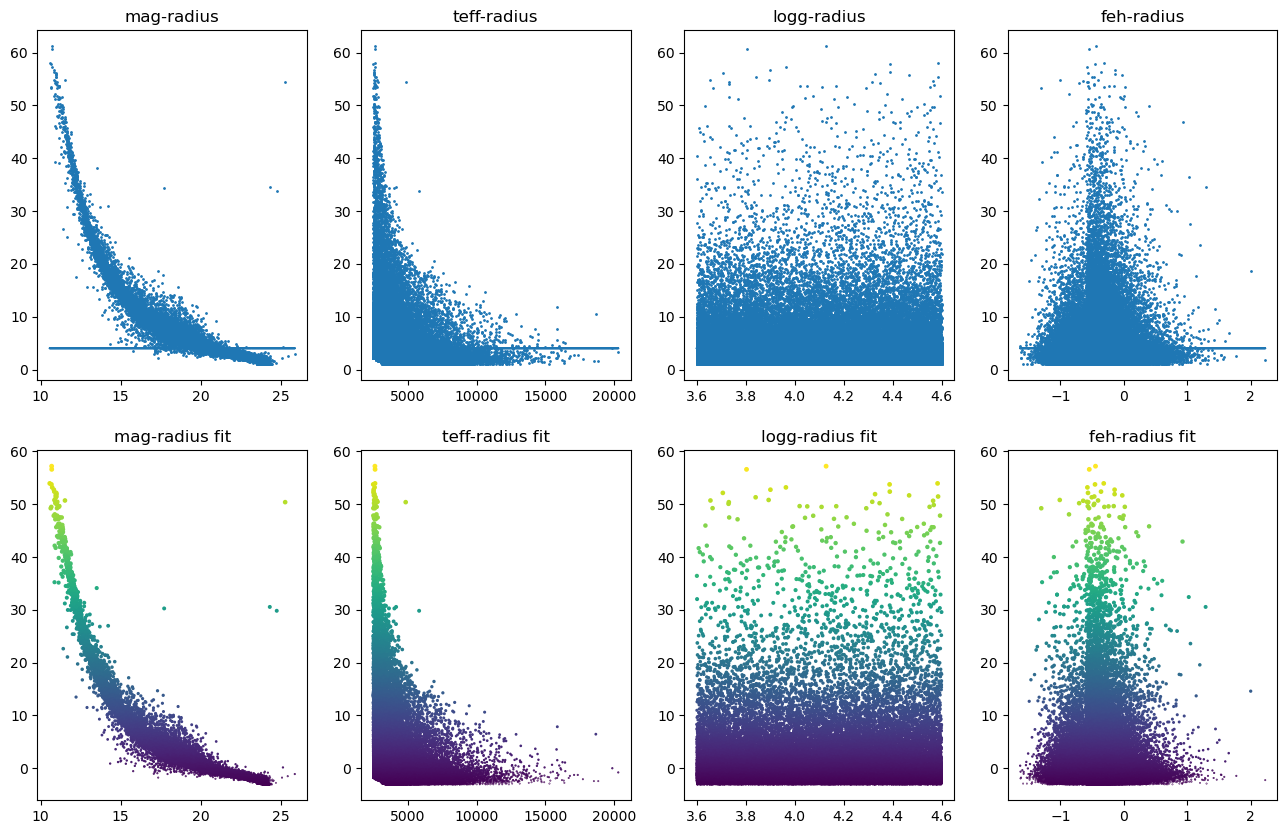

In [44]:
plt.figure(figsize=(16,10))
plt.subplot(241)
plt.scatter(mag,side,s=1)
plt.plot(mag,net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('mag-radius')
plt.subplot(245)
plt.scatter(mag,side-net(torch.tensor(params).float()).squeeze().detach().numpy(),s=side/10,c=side-net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('mag-radius fit')
plt.subplot(242)
plt.scatter(teff,side,s=1)
plt.plot(teff,net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('teff-radius')
plt.subplot(246)
plt.scatter(teff,side-net(torch.tensor(params).float()).squeeze().detach().numpy(),s=side/10,c=side-net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('teff-radius fit')
plt.subplot(243)
plt.scatter(logg,side,s=1)
plt.plot(logg,net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('logg-radius')
plt.subplot(247)
plt.scatter(logg,side-net(torch.tensor(params).float()).squeeze().detach().numpy(),s=side/10,c=side-net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('logg-radius fit')
plt.subplot(244)
plt.scatter(feh,side,s=1)
plt.plot(feh,net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('feh-radius')
plt.subplot(248)
plt.scatter(feh,side-net(torch.tensor(params).float()).squeeze().detach().numpy(),s=side/10,c=side-net(torch.tensor(params).float()).squeeze().detach().numpy())
plt.title('feh-radius fit')

保存以备进一步训练

In [14]:
np.save('__data__/matched_parameters_mtlf.npy',params)
np.save('__data__/matched_sides.npy',side)

### 生成标签数据

In [15]:
import _utils

mag_radius_params = np.load('./__data__/mag_radius_popt.npy')
data_root = './RefineDet/dataset/cf_l_v2/'

side_pixels = 128
side_overlap = 10
nx_split = (img_meta.shape[0]-side_pixels)//(side_pixels-side_overlap) +1   # 去边角料后的x轴图像数
ny_split = (img_meta.shape[1]-side_pixels)//(side_pixels-side_overlap) +1   # 去边角料后的y轴图像数
nxp_split = nx_split*side_pixels - (nx_split-1)*side_overlap                # 去边后x像素数
nyp_split = ny_split*side_pixels - (ny_split-1)*side_overlap                # 去边后y像素数

for i in [data_root,data_root+'/image',data_root+'/catalog']:
    if not os.path.exists(i):
        os.mkdir(i)

# 清除上期数据
if os.path.exists(data_root + 'image/img_0_0.npy'):
    os.system('rm %simage/*'%data_root)
if os.path.exists(data_root + 'catalog/cat_0_0.npy'):
    os.system('rm %scatalog/*'%data_root)

# data
for i in np.arange(0, nxp_split-side_overlap, side_pixels-side_overlap):
    for j in np.arange(0, nyp_split-side_overlap, side_pixels-side_overlap):
        np.save(data_root+'image/img_%s_%s.npy'%(i,j),img_meta[j:j+side_pixels,i:i+side_pixels])  # 震惊！这个居然是倒过来的！
        catij = cat.query('xImage > %f and xImage < %f and yImage > %f and yImage < %f' 
                          % (i,i+side_pixels,j,j+side_pixels)).copy()
        catij['xImage'] -= i
        catij['yImage'] -= j
        # radius = _utils.mag_side(catij['mag'],*mag_radius_params)
        # xmin,xmax = catij['xImage']-radius, catij['xImage']+radius
        # ymin,ymax = catij['yImage']-radius, catij['yImage']+radius
        net = _utils.Mag2Side()
        net.load_state_dict(torch.load('__data__/mag2side_net.pth'))
        radius = net(torch.tensor(catij['mag'].to_numpy()).unsqueeze(1).float()).squeeze().detach().numpy()
        catij = catij[['xImage','yImage']].to_numpy()
        xmin,xmax = catij[:,0]-radius, catij[:,0]+radius
        ymin,ymax = catij[:,1]-radius, catij[:,1]+radius
        
        label = np.ones_like(xmin)
        # label[catij['mag']<18] = 2
        np.save(data_root+'catalog/cat_%s_%s.npy'%(i,j),np.vstack((xmin,ymin,xmax,ymax,label)).T)
        # break

        

In [5]:
radius

array([ 1.2882589,  1.5218843, 10.331329 , ...,  1.418833 ,  3.3643365,
        1.4212625], dtype=float32)

In [6]:
import os

len(os.listdir('/home/haoyanzhen_shao/project/nn_cf/RefineDet/data/cf02/catalog'))

6084

In [6]:
np.load('/home/haoyanzhen_shao/project/nn_cf/RefineDet/dataset/cf_l_v1/catalog/cat_0_0.npy')

array([[ 32.60273798,  20.86773798,  35.01126202,  23.27626202,
          1.        ],
       [119.23839588,  72.77339588, 125.50360412,  79.03860412,
          1.        ],
       [120.79400055,  46.55900055, 130.38799945,  56.15299945,
          1.        ],
       ...,
       [ 74.8816245 ,   9.3806245 ,  77.5963755 ,  12.0953755 ,
          1.        ],
       [ 33.93463671, 115.95563671,  38.12136329, 120.14236329,
          1.        ],
       [ 55.89508965,  82.73208965,  60.71091035,  87.54791035,
          1.        ]])

### 生成标注图像

In [16]:
import numpy as np
from astropy.io import fits

if not data_root:
    data_root = './RefineDet/dataset/cf_l_v2/'
if not os.path.exists(data_root+'/anno'):
    os.mkdir(data_root+'/anno')

np.random.seed(20230417)
file_list = np.array(os.listdir(data_root+'image'))
anno_list = np.random.choice(file_list,10)
# anno_list = ['img_0_118.npy']
# anno_list=['img_0_0.npy']
for i in anno_list:
    i = data_root+'/image/'+i
    image = np.load(i)
    label = np.load(i.split('image')[0]+'/catalog/cat_'+i.split('img_')[1])
    cx = (label[:,2]+label[:,0])/2
    cy = (label[:,1]+label[:,3])/2
    xside = label[:,2]-label[:,0]
    yside = label[:,3]-label[:,1]
    with open(data_root+'/anno/anno_'+i.split('img_')[1][:-4]+'.reg','w') as _r:
        _r.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
        _r.write('physical  \n')
        for idx in range(len(cx)):
            _r.write(f'box({cx[idx]},{cy[idx]},{xside[idx]},{yside[idx]},0)\n')
        # for idx in range(len(cx)):
        #     _r.write(f'circle({cx[idx]},{cy[idx]},{xside[idx]}\5)\n')
    hdu = fits.ImageHDU(image)
    hdu.writeto(data_root+'/anno/anno_'+i.split('img_')[1][:-4]+'.fits',overwrite=True)



In [13]:
os.system('rm /home/haoyanzhen_shao/project/nn_cf/RefineDet/data/cf02/anno/*')

0

# 检验对齐

In [ ]:
cat_check = np.load('/home/haoyanzhen_shao/project/nn_cf/RefineDet/dataset/cf_l_v1/catalog/cat_0_0.npy')
img_check = np.load('/home/haoyanzhen_shao/project/nn_cf/RefineDet/dataset/cf_l_v1/image/img_0_0.npy')
cat_check_center = (cat_check[:,2:4]+cat_check[:,:2])/2
cat_check_centeri = cat_check_center.astype(np.int16)
pixel_center = img_check[cat_check_centeri[:,0],cat_check_centeri[:,1]]
pixel_center

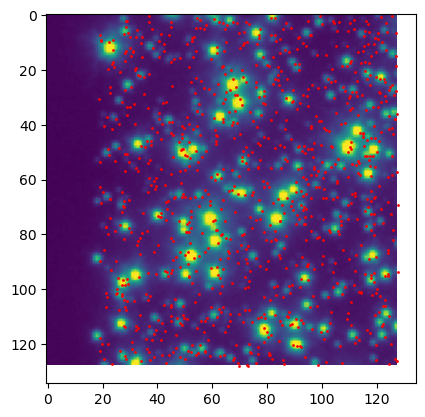

In [94]:
from matplotlib import pyplot as plt

plt.imshow(np.log10(img_check)-300)
plt.scatter(cat_check_center[:,0],cat_check_center[:,1],s=1,c='r')

# others

## 截取不同密度的星场图片

In [30]:
f_sp1 = '/home/haoyanzhen_shao/project/simulation_work/work_dir/Ant_simulation20230310/MSC_0000000/CSST_MSC_MS_SCI_20260310003533_20260310003803_100000000_08_L0_1.fits'
f_sp2 = '/home/haoyanzhen_shao/project/simulation_work/work_dir/NGP_simulation20230304/MSC_0000000/CSST_MSC_MS_SCI_20230517165924_20230517170154_100000000_08_L0_1.fits'
f_cf1 = '/home/haoyanzhen_shao/project/simulation_work/_backup/CrowdedField20230219p/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_07_L0_1.fits'
f_cf2 = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230222/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_08_L0_1.fits'
f_cf3 = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230320/MSC_0000000/CSST_MSC_MS_SCI_20210525120000_20210525120230_100000000_08_L0_1.fits'


In [45]:
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib.collections import PatchCollection
from astropy.io import fits


def fits2png(filelist, dpi=400, seed=None):
    filenum = len(filelist)
    fig, axl = plt.subplots(1,filenum,figsize=(6*filenum,6))
    pic=[]
    for idx, file in enumerate(filelist):
        # read fits to np.array
        img_hdu = fits.open(file)
        img_meta = img_hdu[1].data
        if not seed:
            np.random.seed = seed
        print('seed used: ',seed)
        x,y = np.random.rand(2)*8900+100
        x,y = int(x),int(y)
        img = img_meta[y:y+128,x:x+128]
        ax = (axl if filenum==1 else axl[idx])
        
        pic.append(ax.imshow(np.arcsinh(img),origin='lower',cmap='gray'))
        
        subfig,subax = plt.subplots(1,1,figsize=(6,6))
        subax.imshow(np.arcsinh(img),origin='lower',cmap='gray')
        catpath = os.path.split(file)[0]+'/MSC_100000000_chip_08_filt_g.cat'
        catpath = (catpath if os.path.exists(catpath) else os.path.split(file)[0]+'/MSC_100000000_chip_07_filt_i.cat')
        with open(catpath,'r') as f:
            starnum = len(f.readlines())
        subfig.savefig('__data__/star field samples/%d.png'%starnum,dpi=dpi)
        
    fig.colorbar(pic[-1], ax=axl, shrink=0.7)
    fig.savefig('__data__/star field samples/all.png', dpi=dpi)


seed used:  2023062900
seed used:  2023062900
seed used:  2023062900
seed used:  2023062900


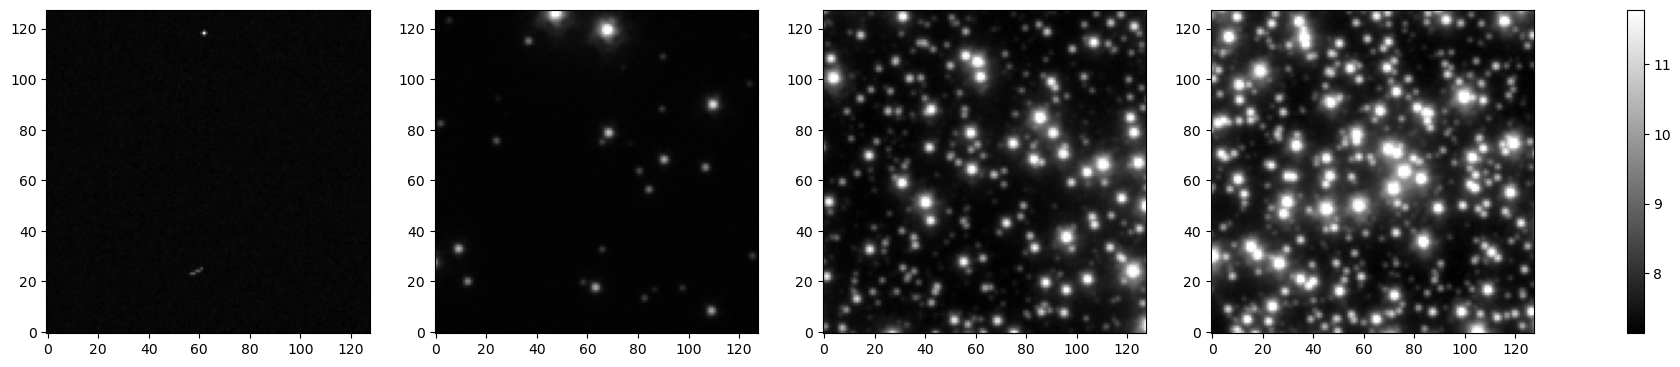

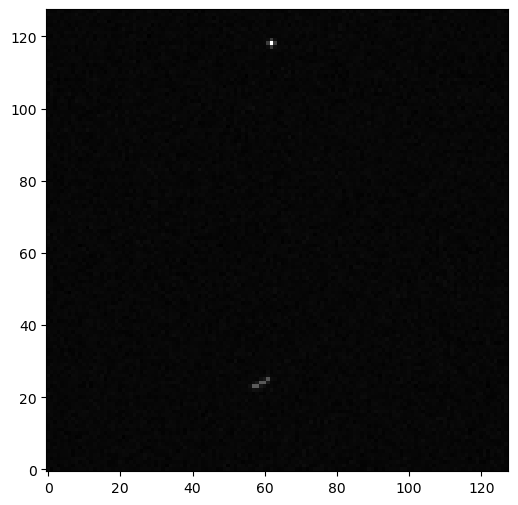

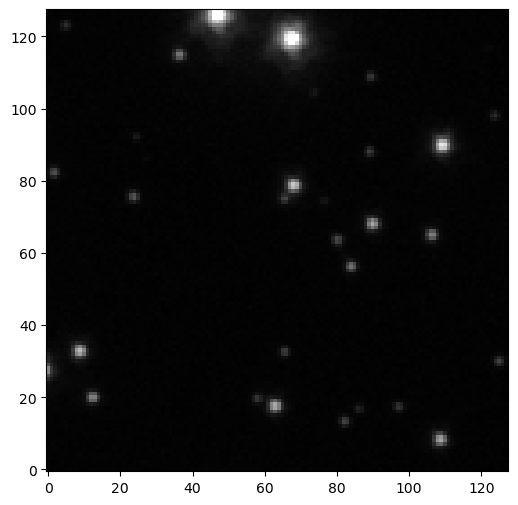

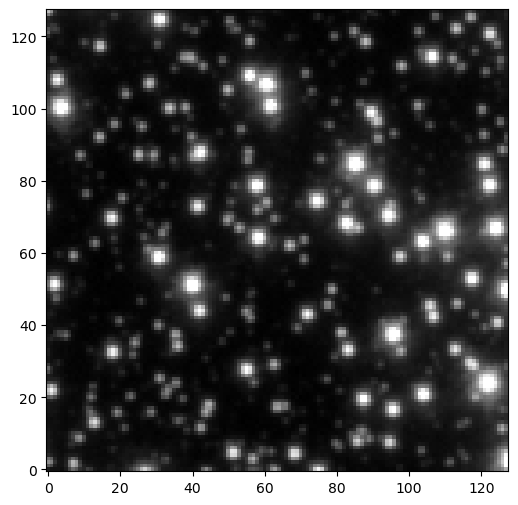

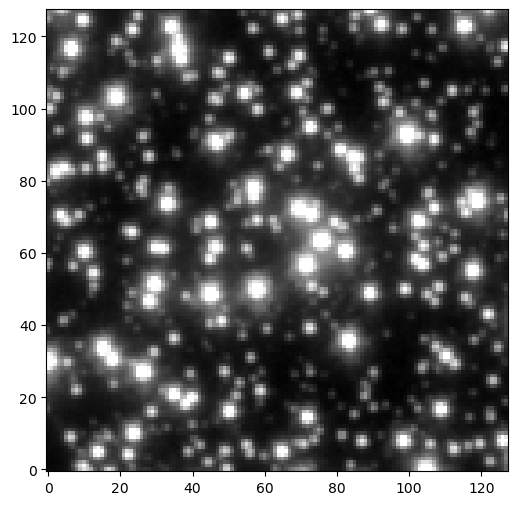

In [46]:
fits2png([f_sp2,f_cf1,f_cf2,f_cf3],dpi=600,seed=2023062900)

In [ ]:
np.asin